In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math



# Define Anchor nodes of system A and system B

In [3]:
AN_sysA = [(30, 200, 40), (100, 200, 10), (0, 0, 30), (200, 100, 20)]
AN_sysB = [(0, 100, 10), (50, 150, 70), (100,100, 100), (200, 200, 60), (100, 0, 20), (200, 0, 30)]
ANs = AN_sysA + AN_sysB

# Define UD locations

In [4]:
UD_orig = (100, 100, 20)
UDs = []
r = 20.0
PI = 3.1416
NUM_EXAMPLES = 3000

for theta in np.arange(0.0, 2*PI*6, 2*PI*6/NUM_EXAMPLES):
    x = r * math.cos(theta) + UD_orig[0]
    y = r * math.sin(theta) + UD_orig[1]
    z = theta + UD_orig[2]
    UDs.append((x, y, z))

In [5]:
len(UDs)

3000


# 3D scatterplot


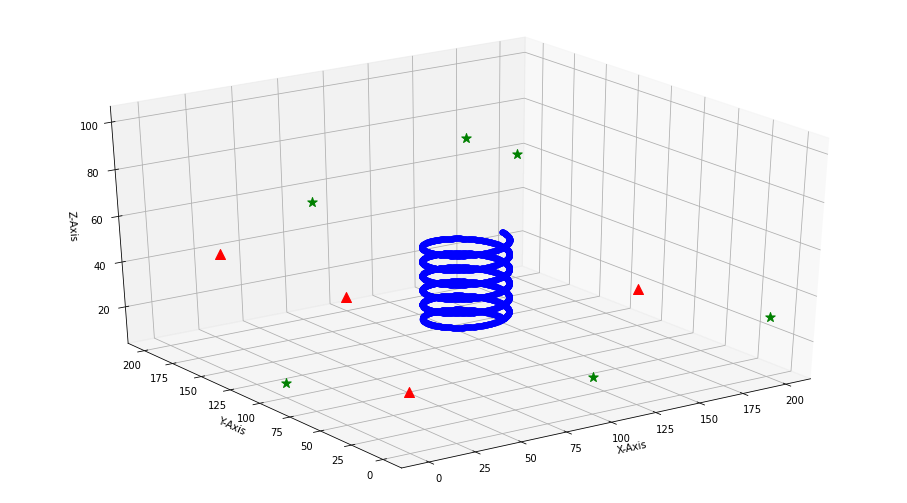

In [6]:
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(azim=235, elev=30)   # set view port according to the fig.4 in paper

# plot AN points for system A
marker = '^'
for xs, ys, zs in AN_sysA:
    ax.scatter(xs, ys, zs, marker=marker, c='r', s=100)

# plot AN points for system B
marker = '*'
for xs, ys, zs in AN_sysB:
    ax.scatter(xs, ys, zs, marker=marker, c='g', s=100)

# plot UD points
marker = '.'
for xs, ys, zs in UDs:
    ax.scatter(xs, ys, zs, marker=marker, c='b', s=100)

    
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')


plt.show()

# Generate dataset  by computing the distances between UD and ANs
# The dataset is defined to be (3000, 13) 

In [7]:
def compute_3d_distance(p1, p2):
    x1 = p1[0]
    y1 = p1[1]
    z1 = p1[2]
    x2 = p2[0]
    y2 = p2[1]
    z2 = p2[2]
    
    d = math.sqrt((x2 - x1)**2 + (y2 - y1)**2 + (z2 - z1)**2)
    return d

In [8]:
# Generate the dataset without any noise
i = 0
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        d = compute_3d_distance(ud, an)
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  

# Try to show the 1st example of my_dataset for verification

In [9]:
my_dataset[0]   # Looks fine

[136.01470508735443,
 102.46950765959599,
 156.52475842498527,
 80.0,
 120.41594578792295,
 99.498743710662,
 82.46211251235322,
 134.16407864998737,
 101.9803902718557,
 128.4523257866513,
 120.0,
 100.0,
 20.0]

# Field Explaination of my_dataset
## Example of my_dataset = [rA0, rA1, rA2, rA3, rB0, rB1,rB2, rB3, rB4, rB5, x, y, z]

    * rA0, rA1, rA2, rA3, rB0, rB1, ... rB5: distance between ANi to UD (in meters)
    * x, y, z:  UD location (in meters, ground truth)

# Verify the dataset dimension

In [10]:
import numpy as np
A = np.array(my_dataset)   #  expect to be (3000, 13)
A.shape

(3000, 13)

# Dataset loader and data preprocessing

In [11]:
import glob
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import csv
import random
import numpy as np
import os

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
class Exercise5Dataset(Dataset):
    """Exercise5 dataset."""
    def __init__(self, list_dataset, shuffle=False):
        """
        Args:
        list_dataset (list): Directory with the dataset files.
        shuffle (bool): Shuffle or not
        """
        self.all_data = list_dataset

        # Reorder the sequence of the dataset
        if shuffle:
            random.shuffle(self.all_data)
            print("Dataset shuffle = True!")

        ### Data preprocessing
        # Compute dataset mean and std
        examples = torch.from_numpy(np.array(self.all_data)[:, :10]).float()    
        #print(examples.shape) # (3000, 10)
        self.labels = torch.from_numpy(np.array(self.all_data)[:, 10:]).float()
        #print(self.labels.shape)  #(3000, 3)

        # Compute mean and std
        mu = examples.mean(dim=0)
        sigma = examples.std(dim=0, unbiased=False)

        # Compute normalized examples:
        x_prime = (x - mu) / sigma
        self.normalized_examples = (examples - mu) / sigma

    
    def __len__(self):
        return len(self.normalized_examples)
    
    def __getitem__(self, idx):
        example = self.normalized_examples[idx]   #(N, 10)
        xyz = self.labels[idx]   #(N,3)
        return example, xyz

# Load the whole dataset

In [13]:
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)   #Load dataset

Dataset shuffle = True!


In [14]:
len(exercise5_dataset)

3000

# Split dataset by 0.8: 0.1: 0.1

In [15]:
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

In [16]:
print(train_examples.shape)
print(train_labels.shape)
print(val_examples.shape)
print(val_labels.shape)
print(test_examples.shape)
print(test_labels.shape)


torch.Size([2400, 10])
torch.Size([2400, 3])
torch.Size([300, 10])
torch.Size([300, 3])
torch.Size([300, 10])
torch.Size([300, 3])


# Define our model structure

In [17]:
# MYLSTM
class MYLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bidirectional=False):
        super(MYLSTM, self).__init__()
        # 這樣他就接受input dim (batch_size, seq_len, input_size)
        # 注意這個model跟batch_size & seq_len無關, 所以可以接受不同大小batch_size & seq_len
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            #bidirectional=bidirectional,
        )

        self.fc = nn.Linear(hidden_size, 3)   # final output dim is (N, 3)
        #self.sigmoid = nn.Sigmoid()

    def forward(self, inputs):
        out, (h, c) = self.lstm(inputs, None)
        #print("[KK] inputs.shape: ", inputs.shape)
        #print("[KK] h[-1].shape: ", h[-1].shape)
        #print("[KK] h[-1].squeeze(0).shape: ", h[-1].squeeze(0).shape)
        
        fc_outputs = self.fc(h[-1].squeeze(0))
        #print("[KK] outputs.shape: ", outputs.shape)

        return fc_outputs

# Define model, loss function and optimizer

In [18]:
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [19]:
print(device)
print(model)

cuda:0
MYLSTM(
  (lstm): LSTM(1, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=3, bias=True)
)


# Correct the input/output shape

In [20]:
# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Training and Validation

In [21]:
# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 10.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    
    # check if we got better loss
    if loss < best_loss:
        best_loss = loss
        torch.save(model.state_dict(), MODEL_FILENAME)   # save the model

    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model


epoch:  0 train_loss: 7368.60498046875 val_loss: 7390.89013671875
epoch:  100 train_loss: 6059.06787109375 val_loss: 6068.29833984375
epoch:  200 train_loss: 5138.39013671875 val_loss: 5146.056640625
epoch:  300 train_loss: 4380.10400390625 val_loss: 4385.97265625
epoch:  400 train_loss: 3734.226318359375 val_loss: 3738.318359375
epoch:  500 train_loss: 3179.090087890625 val_loss: 3181.87109375
epoch:  600 train_loss: 2701.050048828125 val_loss: 2702.257568359375
epoch:  700 train_loss: 2288.547119140625 val_loss: 2288.824951171875
epoch:  800 train_loss: 1909.179443359375 val_loss: 1908.6697998046875
epoch:  900 train_loss: 1595.8544921875 val_loss: 1594.907958984375
epoch:  1000 train_loss: 1331.42822265625 val_loss: 1330.230712890625
epoch:  1100 train_loss: 1108.134521484375 val_loss: 1107.0162353515625
epoch:  1200 train_loss: 920.6688232421875 val_loss: 919.5908813476562
epoch:  1300 train_loss: 764.4835205078125 val_loss: 763.5940551757812
epoch:  1400 train_loss: 635.5841064453

# Plot the Loss history for training set and validation set

In [22]:
import matplotlib.pyplot as plt
def show_train_history(train_history, val_history):
    plt.rcParams["figure.figsize"] = (15, 5)
    plt.plot(np.log(train_history))
    plt.plot(np.log(val_history))
    plt.title("Train_history")
    plt.ylabel("Log(MSELoss)")
    plt.xlabel("Epoch")
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

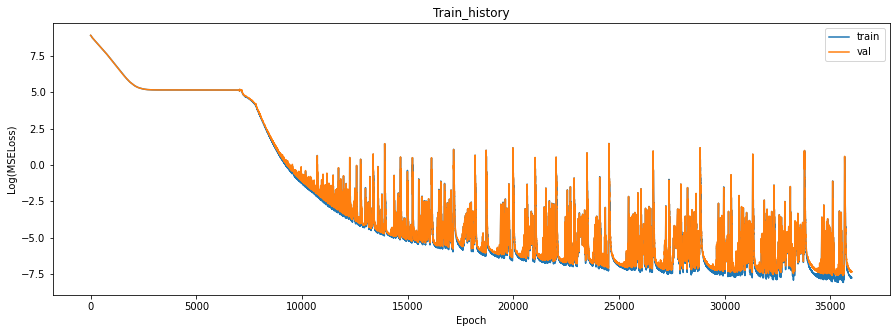

In [23]:
show_train_history(train_losses, val_losses)

# Load the best model on previous step

In [24]:
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

# Inference a single testing example

In [25]:
def euclidean_distance(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  euclidena_dist = torch.sqrt(loss_fn(a, b))
  return euclidena_dist

model.eval() # inference mode
idx = 188

test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels =  test_labels.to(device)

test_input =  torch.unsqueeze(test_inputs[idx], dim=0)  #(10,1) -> (1, 10, 1)
print(test_input.shape)
test_label = test_labels[idx]
test_pred = model(test_input)
print("example: ", test_input.cpu())
print("========================================")
print("ground_truth (x, y, z in meters): ", test_label.cpu())
print("prediction (x, y, z in meters): ", test_pred.cpu())
print("========================================")


#print("Loss: ",  loss_fn(test_pred, test_label).cpu())
print("Error (euclidean distance in meters): ",  euclidean_distance(test_pred, test_label).cpu())


torch.Size([1, 10, 1])
example:  tensor([[[ 0.6579],
         [ 1.4555],
         [-1.2833],
         [ 0.9791],
         [-0.2415],
         [ 0.0059],
         [-1.5257],
         [ 1.2105],
         [-0.9333],
         [-0.1988]]])
ground_truth (x, y, z in meters):  tensor([89.9290, 82.7207, 55.6006])
prediction (x, y, z in meters):  tensor([89.9310, 82.7032, 55.6131], grad_fn=<CopyBackwards>)
Error (euclidean distance in meters):  tensor(0.0216, grad_fn=<CopyBackwards>)


# Inference all testing examples and compute RMSE

In [26]:
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels =  test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("RMSE: ",  RMSE)


RMSE:  tensor(0.0341, device='cuda:0', grad_fn=<SqrtBackward>)


# Plot the test set prediction results

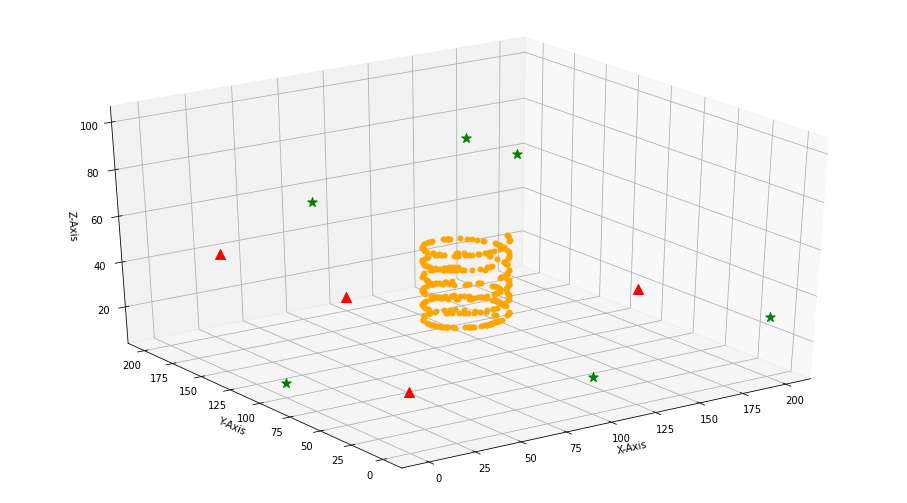

In [27]:
plt.rcParams["figure.figsize"] = (16, 9)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(azim=235, elev=30)   # set view port to fit the fig.4 in paper

# plot AN points for system A
marker = '^'
for xs, ys, zs in AN_sysA:
    ax.scatter(xs, ys, zs, marker=marker, c='r', s=100)

# plot AN points for system B
marker = '*'
for xs, ys, zs in AN_sysB:
    ax.scatter(xs, ys, zs, marker=marker, c='g', s=100)

# plot testset prediction points
marker = '.'
for xs, ys, zs in test_preds.cpu().detach().numpy():
    ax.scatter(xs, ys, zs, marker=marker, c='orange', s=100)

    
ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_zlabel('Z-Axis')


plt.show()

In [28]:
# Empty sigmas and RMSEs
sigmas = []
RMSEs = []

# NOW we are going to add measurement noises into the dataset
* Based on the paper, we will add some noise into measurements r by N(0, sigma), 
* sigma = 0.1, 1.0, 1,9, 2.8, 3.7, 4.6, 5.5, 6.4, 7.3, 8.2, 9.1, 10.0 respectively.


# Then, We will retrain 12 models and evaluate the RMSEs.

# Sigma = 0.1

In [29]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 0.1
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7334.25537109375 val_loss: 7244.10107421875
epoch:  100 train_loss: 5912.68017578125 val_loss: 5822.01806640625
epoch:  200 train_loss: 5004.66455078125 val_loss: 4920.923828125
epoch:  300 train_loss: 4254.7822265625 val_loss: 4176.927734375
epoch:  400 train_loss: 3616.832275390625 val_loss: 3544.433349609375
epoch:  500 train_loss: 3069.88818359375 val_loss: 3002.862060546875
epoch:  600 train_loss: 2599.6162109375 val_loss: 2537.73779296875
epoch:  700 train_loss: 2194.963623046875 val_loss: 2138.031982421875
epoch:  800 train_loss: 1847.146484375 val_loss: 1795.0030517578125
epoch:  900 train_loss: 1548.99169921875 val_loss: 1501.3828125
epoch:  1000 train_loss: 1294.4736328125 val_loss: 1251.3231201171875
epoch:  1100 train_loss: 1078.5166015625 val_loss: 1039.729736328125
epoch:  1200 train_loss: 896.6746215820312 val_loss: 862.0421142578125
epoch:  1300 train_loss: 745.1541137695312 val_loss: 714.0287475585938
epoch:  1400 train_los

# Sigma = 1.0

In [30]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 1.0
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7313.40869140625 val_loss: 7433.78369140625
epoch:  100 train_loss: 5946.6279296875 val_loss: 6051.322265625
epoch:  200 train_loss: 5023.58447265625 val_loss: 5123.6298828125
epoch:  300 train_loss: 4267.34326171875 val_loss: 4362.455078125
epoch:  400 train_loss: 3626.171142578125 val_loss: 3715.88623046875
epoch:  500 train_loss: 3076.933349609375 val_loss: 3161.3212890625
epoch:  600 train_loss: 2604.886962890625 val_loss: 2683.823486328125
epoch:  700 train_loss: 2199.042724609375 val_loss: 2272.45068359375
epoch:  800 train_loss: 1850.475341796875 val_loss: 1917.9718017578125
epoch:  900 train_loss: 1551.568359375 val_loss: 1613.582275390625
epoch:  1000 train_loss: 1296.630126953125 val_loss: 1353.1602783203125
epoch:  1100 train_loss: 1080.37353515625 val_loss: 1131.628173828125
epoch:  1200 train_loss: 898.3497924804688 val_loss: 944.280029296875
epoch:  1300 train_loss: 746.4129638671875 val_loss: 787.5970458984375
epoch:  1400 tr

# Sigma = 1.9

In [31]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 1.9
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7323.82958984375 val_loss: 7367.9365234375
epoch:  100 train_loss: 5918.06396484375 val_loss: 5948.935546875
epoch:  200 train_loss: 4995.9296875 val_loss: 5023.96337890625
epoch:  300 train_loss: 4240.40478515625 val_loss: 4265.703125
epoch:  400 train_loss: 3599.52392578125 val_loss: 3622.12841796875
epoch:  500 train_loss: 3051.093994140625 val_loss: 3071.300048828125
epoch:  600 train_loss: 2580.416015625 val_loss: 2598.6015625
epoch:  700 train_loss: 2176.310791015625 val_loss: 2192.5009765625
epoch:  800 train_loss: 1829.499267578125 val_loss: 1844.273681640625
epoch:  900 train_loss: 1532.8216552734375 val_loss: 1546.019775390625
epoch:  1000 train_loss: 1279.9588623046875 val_loss: 1291.985595703125
epoch:  1100 train_loss: 1065.864013671875 val_loss: 1076.725341796875
epoch:  1200 train_loss: 885.6777954101562 val_loss: 895.7160034179688
epoch:  1300 train_loss: 735.5491333007812 val_loss: 744.9340209960938
epoch:  1400 train_loss:

# Sigma = 2.8

In [32]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 2.8
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7318.8310546875 val_loss: 7423.31982421875
epoch:  100 train_loss: 5998.41455078125 val_loss: 6087.52587890625
epoch:  200 train_loss: 5108.8525390625 val_loss: 5194.3125
epoch:  300 train_loss: 4366.9404296875 val_loss: 4447.64111328125
epoch:  400 train_loss: 3707.647216796875 val_loss: 3784.12451171875
epoch:  500 train_loss: 3151.73779296875 val_loss: 3223.748779296875
epoch:  600 train_loss: 2674.996826171875 val_loss: 2742.5009765625
epoch:  700 train_loss: 2243.298095703125 val_loss: 2305.486083984375
epoch:  800 train_loss: 1879.8555908203125 val_loss: 1937.37646484375
epoch:  900 train_loss: 1572.6953125 val_loss: 1625.40283203125
epoch:  1000 train_loss: 1312.2440185546875 val_loss: 1360.2550048828125
epoch:  1100 train_loss: 1092.172119140625 val_loss: 1135.5645751953125
epoch:  1200 train_loss: 907.1878662109375 val_loss: 946.393798828125
epoch:  1300 train_loss: 753.3662719726562 val_loss: 788.2512817382812
epoch:  1400 train_l

# Sigma = 3.7

In [33]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 3.7
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7335.892578125 val_loss: 7412.7822265625
epoch:  100 train_loss: 5926.85791015625 val_loss: 5990.75439453125
epoch:  200 train_loss: 5024.87890625 val_loss: 5087.6845703125
epoch:  300 train_loss: 4278.263671875 val_loss: 4339.1533203125
epoch:  400 train_loss: 3641.87841796875 val_loss: 3700.428466796875
epoch:  500 train_loss: 3095.662841796875 val_loss: 3151.4921875
epoch:  600 train_loss: 2625.489501953125 val_loss: 2678.5478515625
epoch:  700 train_loss: 2220.937744140625 val_loss: 2270.500244140625
epoch:  800 train_loss: 1872.672119140625 val_loss: 1919.08740234375
epoch:  900 train_loss: 1573.9222412109375 val_loss: 1616.776123046875
epoch:  1000 train_loss: 1318.5897216796875 val_loss: 1357.95751953125
epoch:  1100 train_loss: 1101.4368896484375 val_loss: 1137.4305419921875
epoch:  1200 train_loss: 918.3193359375 val_loss: 950.5076904296875
epoch:  1300 train_loss: 764.8369750976562 val_loss: 793.851318359375
epoch:  1400 train_los

# Sigma = 4.6

In [34]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 4.6
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7339.33056640625 val_loss: 7317.88232421875
epoch:  100 train_loss: 5976.46630859375 val_loss: 5953.708984375
epoch:  200 train_loss: 5072.2099609375 val_loss: 5055.4306640625
epoch:  300 train_loss: 4316.51806640625 val_loss: 4304.58251953125
epoch:  400 train_loss: 3663.818359375 val_loss: 3655.4150390625
epoch:  500 train_loss: 3095.794677734375 val_loss: 3090.764892578125
epoch:  600 train_loss: 2615.93994140625 val_loss: 2613.494140625
epoch:  700 train_loss: 2205.67529296875 val_loss: 2205.3017578125
epoch:  800 train_loss: 1854.2872314453125 val_loss: 1855.2181396484375
epoch:  900 train_loss: 1553.71240234375 val_loss: 1555.5379638671875
epoch:  1000 train_loss: 1297.595458984375 val_loss: 1300.1630859375
epoch:  1100 train_loss: 1080.6861572265625 val_loss: 1083.454833984375
epoch:  1200 train_loss: 898.1596069335938 val_loss: 901.1116333007812
epoch:  1300 train_loss: 746.0665893554688 val_loss: 748.9627075195312
epoch:  1400 trai

# Sigma = 5.5

In [35]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 5.5
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7324.1953125 val_loss: 7262.0947265625
epoch:  100 train_loss: 5908.982421875 val_loss: 5844.51904296875
epoch:  200 train_loss: 5002.35546875 val_loss: 4942.93359375
epoch:  300 train_loss: 4250.24560546875 val_loss: 4195.173828125
epoch:  400 train_loss: 3609.9189453125 val_loss: 3558.659912109375
epoch:  500 train_loss: 3061.1982421875 val_loss: 3013.77197265625
epoch:  600 train_loss: 2589.735595703125 val_loss: 2546.04052734375
epoch:  700 train_loss: 2184.65966796875 val_loss: 2144.5830078125
epoch:  800 train_loss: 1837.078369140625 val_loss: 1800.4219970703125
epoch:  900 train_loss: 1539.584228515625 val_loss: 1506.341552734375
epoch:  1000 train_loss: 1285.9447021484375 val_loss: 1255.906982421875
epoch:  1100 train_loss: 1071.103759765625 val_loss: 1044.1871337890625
epoch:  1200 train_loss: 890.3026733398438 val_loss: 866.4234008789062
epoch:  1300 train_loss: 739.5667114257812 val_loss: 718.6979370117188
epoch:  1400 train_loss

# Sigma = 6.4

In [36]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 6.4
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7337.568359375 val_loss: 7340.720703125
epoch:  100 train_loss: 5922.626953125 val_loss: 5915.2412109375
epoch:  200 train_loss: 5020.3935546875 val_loss: 5012.02587890625
epoch:  300 train_loss: 4269.97216796875 val_loss: 4260.5947265625
epoch:  400 train_loss: 3630.572265625 val_loss: 3620.152587890625
epoch:  500 train_loss: 3081.640625 val_loss: 3070.71240234375
epoch:  600 train_loss: 2609.52978515625 val_loss: 2598.3212890625
epoch:  700 train_loss: 2203.5263671875 val_loss: 2192.05078125
epoch:  800 train_loss: 1854.544189453125 val_loss: 1843.240966796875
epoch:  900 train_loss: 1555.429443359375 val_loss: 1544.628173828125
epoch:  1000 train_loss: 1300.189697265625 val_loss: 1289.852294921875
epoch:  1100 train_loss: 1083.6239013671875 val_loss: 1074.0250244140625
epoch:  1200 train_loss: 901.3701782226562 val_loss: 892.45556640625
epoch:  1300 train_loss: 749.2096557617188 val_loss: 740.92578125
epoch:  1400 train_loss: 623.389892

# Sigma = 7.3

In [37]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 7.3
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7343.42919921875 val_loss: 7287.8662109375
epoch:  100 train_loss: 5976.57568359375 val_loss: 5918.86328125
epoch:  200 train_loss: 5042.6083984375 val_loss: 4992.001953125
epoch:  300 train_loss: 4280.9482421875 val_loss: 4235.93798828125
epoch:  400 train_loss: 3635.251708984375 val_loss: 3594.9833984375
epoch:  500 train_loss: 3082.718994140625 val_loss: 3046.69287109375
epoch:  600 train_loss: 2608.20556640625 val_loss: 2576.18310546875
epoch:  700 train_loss: 2200.729736328125 val_loss: 2172.138427734375
epoch:  800 train_loss: 1850.9842529296875 val_loss: 1825.4766845703125
epoch:  900 train_loss: 1551.6112060546875 val_loss: 1528.791748046875
epoch:  1000 train_loss: 1296.4017333984375 val_loss: 1275.90869140625
epoch:  1100 train_loss: 1079.931396484375 val_loss: 1061.7158203125
epoch:  1200 train_loss: 897.868408203125 val_loss: 881.6083374023438
epoch:  1300 train_loss: 746.0778198242188 val_loss: 731.5398559570312
epoch:  1400 tr

# Sigma = 8.2

In [38]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 8.2
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7349.2734375 val_loss: 7329.3701171875
epoch:  100 train_loss: 5890.2734375 val_loss: 5864.9521484375
epoch:  200 train_loss: 4980.46240234375 val_loss: 4958.20556640625
epoch:  300 train_loss: 4228.64208984375 val_loss: 4208.484375
epoch:  400 train_loss: 3589.34033203125 val_loss: 3570.928955078125
epoch:  500 train_loss: 3041.875 val_loss: 3024.947509765625
epoch:  600 train_loss: 2571.98779296875 val_loss: 2556.7509765625
epoch:  700 train_loss: 2168.476318359375 val_loss: 2154.805908203125
epoch:  800 train_loss: 1822.559814453125 val_loss: 1810.1375732421875
epoch:  900 train_loss: 1526.5711669921875 val_loss: 1515.5179443359375
epoch:  1000 train_loss: 1274.52783203125 val_loss: 1264.7197265625
epoch:  1100 train_loss: 1061.159423828125 val_loss: 1052.4232177734375
epoch:  1200 train_loss: 881.7615966796875 val_loss: 874.14013671875
epoch:  1300 train_loss: 732.418212890625 val_loss: 725.6917114257812
epoch:  1400 train_loss: 609.060

# Sigma = 9.1

In [39]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 9.1
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7331.41259765625 val_loss: 7341.69921875
epoch:  100 train_loss: 5954.142578125 val_loss: 5954.005859375
epoch:  200 train_loss: 5039.732421875 val_loss: 5038.0126953125
epoch:  300 train_loss: 4283.04150390625 val_loss: 4279.35302734375
epoch:  400 train_loss: 3639.01513671875 val_loss: 3633.718994140625
epoch:  500 train_loss: 3087.030029296875 val_loss: 3080.50732421875
epoch:  600 train_loss: 2612.580078125 val_loss: 2605.1728515625
epoch:  700 train_loss: 2204.959716796875 val_loss: 2197.12890625
epoch:  800 train_loss: 1854.9390869140625 val_loss: 1846.9747314453125
epoch:  900 train_loss: 1555.193115234375 val_loss: 1547.4566650390625
epoch:  1000 train_loss: 1299.6947021484375 val_loss: 1292.14306640625
epoch:  1100 train_loss: 1083.014404296875 val_loss: 1075.9920654296875
epoch:  1200 train_loss: 900.7398681640625 val_loss: 894.149658203125
epoch:  1300 train_loss: 748.6314086914062 val_loss: 742.599365234375
epoch:  1400 train_lo

# Sigma = 10.0

In [40]:
# Generate the dataset with noise N(0, sigma)
i = 0
sigma = 10.0
my_dataset = []
for ud in UDs:
    example = []
    for an in ANs:
        noise = np.random.normal(0,sigma)
        # 0 is mean
        # sigma is the deviation of the normal distribution
        d = compute_3d_distance(ud, an) + noise
        example.append(d)
    
    # append x, y, z as col#10, #11, #12
    example.append(ud[0])
    example.append(ud[1])
    example.append(ud[2])
    
    # append 1x13 example row into my_dataset
    my_dataset.append(example)  # expected to be 3000x13  
    
# Load dataset
exercise5_dataset = Exercise5Dataset(list_dataset = my_dataset, shuffle=True)

#Split dataset by 0.8: 0.1: 0.1
train_examples, train_labels = exercise5_dataset[:int(3000*0.8)]  # (2400, 10)   # (2400, 3)
val_examples, val_labels = exercise5_dataset[int(3000*0.8):int(3000*0.9)]    # (300, 10)   #(300, 3)
test_examples, test_labels = exercise5_dataset[int(3000*0.9):]     #(300, 10)   # (300, 3)

###Define model, loss function and optimizer
# if we have GPU, then use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# define model
#model = Net(x_dim = train_examples.shape[1], y_dim = train_labels.shape[1]).to(device)
input_dim = 1     #input dim is 1, seq_len = 10
hidden_dim = 64   #hidden state dim is 64
n_layers = 3             #3-layered LSTM
model = MYLSTM(input_dim, hidden_dim, n_layers).to(device)

# define loss function and optimizer
loss_fn = nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Correct the input/output shape for LSTM
train_inputs = torch.unsqueeze(train_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
train_inputs = train_inputs.to(device) 

val_inputs = torch.unsqueeze(val_examples, dim=-1)   # (N, 10) -> (N, 10, 1)
val_inputs = val_inputs.to(device) 

train_labels = train_labels.to(device)   #(N, 3)
val_labels = val_labels.to(device)          #(N, 3)


# Define the loss threshold, if the current train loss is lower than the threshold, we will begin to save the model
best_loss = 100.0

# Define the model filename for model.save()
MODEL_FILENAME = "best.pth"

# set model to Training mode
model.train()
train_losses = []
val_losses = []

NUM_OF_EPOCH = 36000

# Train
for epoch in range(NUM_OF_EPOCH):
    y_pred = model(train_inputs)
    loss = loss_fn(y_pred, train_labels).cpu()
    #print(t, loss.item())
    train_losses.append(loss.item())
    # clear gradients
    optimizer.zero_grad()
    # compute gradients
    loss.backward()
    # BGD
    optimizer.step()
    
    # evaluate validation loss
    val_pred = model(val_inputs)
    loss = loss_fn(val_pred, val_labels)
    val_losses.append(loss.item())
    


    if (epoch % 100) == 0:
        print("epoch: ", epoch, "train_loss:", train_losses[-1], "val_loss:", val_losses[-1])
        # check if we got better loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), MODEL_FILENAME)   # save the model
        
# Load the best model on previous step
model.load_state_dict(torch.load("best.pth"))

# Inference all testing examples and compute RMSE
def square_error(a, b):
  loss_fn = nn.MSELoss(reduction='sum')  
  square_error= loss_fn(a, b)
  return square_error

model.eval() # inference mode
test_inputs = torch.unsqueeze(test_examples, dim=-1)  #  (N, 10) -> (N, 10, 1)   
test_inputs = test_inputs.to(device)
test_labels = test_labels.to(device)

test_preds = model(test_inputs)
#print("example: ", test_example.cpu())
#print("========================================")
#print("ground_truth:", test_label.cpu())
#print("prediction:", test_pred.cpu())
#print("========================================")


total_errors = 0.0
for idx in range(len(test_inputs)):
    total_errors += square_error(test_preds[idx], test_labels[idx])
    
RMSE = torch.sqrt(total_errors / len(test_inputs))
print("sigma:", sigma, "RMSE: ",  RMSE)

sigmas.append(sigma)
RMSEs.append(RMSE.cpu().detach().item())

Dataset shuffle = True!
epoch:  0 train_loss: 7313.5078125 val_loss: 7412.6689453125
epoch:  100 train_loss: 5996.3876953125 val_loss: 6079.244140625
epoch:  200 train_loss: 5076.19384765625 val_loss: 5154.62255859375
epoch:  300 train_loss: 4315.88720703125 val_loss: 4389.4287109375
epoch:  400 train_loss: 3669.02294921875 val_loss: 3737.62353515625
epoch:  500 train_loss: 3114.13330078125 val_loss: 3178.19677734375
epoch:  600 train_loss: 2637.292236328125 val_loss: 2696.657470703125
epoch:  700 train_loss: 2227.0234375 val_loss: 2282.11083984375
epoch:  800 train_loss: 1874.7198486328125 val_loss: 1925.306396484375
epoch:  900 train_loss: 1572.7000732421875 val_loss: 1619.1895751953125
epoch:  1000 train_loss: 1314.91650390625 val_loss: 1357.4150390625
epoch:  1100 train_loss: 1096.1214599609375 val_loss: 1134.814208984375
epoch:  1200 train_loss: 911.943359375 val_loss: 946.9263916015625
epoch:  1300 train_loss: 757.89892578125 val_loss: 789.6646728515625
epoch:  1400 train_loss: 6

# Plot the RMSE by measurement noise diagram

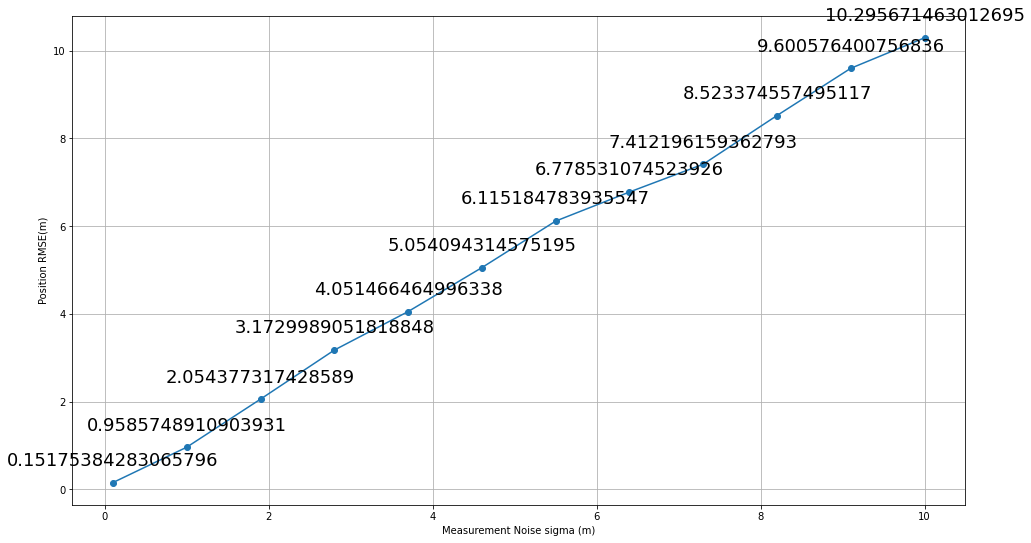

In [41]:
#sigmas = [0.1, 1.0, 1.9, 2.8, 3.7, 4.6, 5.5, 6.4, 7.3, 8.2, 9.1, 10.0]
#RMSEs = [0.4948, 1.0454, 2.2507, 3.4022, 4.6365, 6.0840, 8.3602, 9.2469, 10.0984, 11.3101, 12.7875, 13.5534]
plt.ylabel("Position RMSE(m)")
plt.xlabel("Measurement Noise sigma (m)")
plt.grid(True)
plt.plot(sigmas, RMSEs, marker='o')

for a, b in zip(sigmas, RMSEs):
    plt.text(a, b+0.3, b, ha='center', va='bottom', fontsize=18)
plt.show()